## Homework: Deep Jazz

In [1]:
import numpy as np
from music21 import stream, midi, tempo, note

from grammar import unparse_grammar
from preprocess import get_musical_data, get_corpus_data

from qa import prune_grammar, prune_notes, clean_up_notes
from generator import __sample, __generate_grammar, __predict

In [2]:
N_epochs = 128  # default
data_fn = 'midi/' + 'original_metheny.mid'  # 'And Then I Knew' by Pat Metheny
out_fn = 'midi/' 'deepjazz_on_metheny_' + str(N_epochs) + '_epochs.midi'

In [3]:
max_len = 20
max_tries = 1000
diversity = 0.5

# musical settings
bpm = 130

# get data
chords, abstract_grammars = get_musical_data(data_fn)
corpus, values, val_indices, indices_val = get_corpus_data(abstract_grammars)
print('corpus length:', len(corpus))
print('total # of values:', len(values))

corpus length: 193
total # of values: 78


In [4]:
chords[0]

[<music21.instrument.Piano Piano>,
 <music21.tempo.MetronomeMark Quarter=112.0>,
 <music21.key.Key of G major>,
 <music21.meter.TimeSignature 4/4>]

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

def get_keras_model(max_len, N_values):
    # build a 2 stacked LSTM
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(max_len, N_values)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(N_values))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

Using TensorFlow backend.


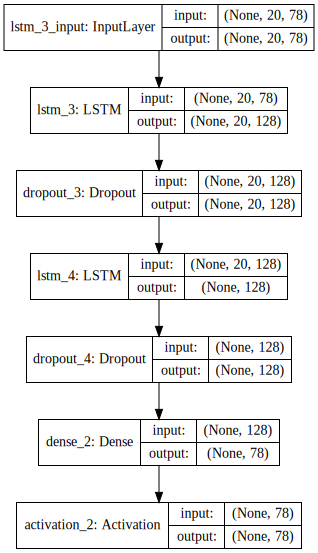

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(get_keras_model(20, 78), show_shapes=True).create(prog='dot', format='svg'))

## Task

Replace previous model with equivalent in prettytensor or tf.slim

Try to make you code as compact as possible

In [12]:
import tensorflow as tf
import prettytensor as pt

In [120]:
# С prettytensor ничего не получилось =(

class PTModel:
    def __init__(self, max_len, N_values):
        self.max_len = max_len
        self.N_values = N_values
        self.session = tf.Session()
        
    def _create_model(self, phase, batch_size):
        self.inputs = self.__reshape_data(self.input_placeholder, 
                                          per_example_length=self.N_values)
        self.labels = self.__reshape_data(
            tf.reshape(
                tf.tile(
                    self.label_placeholder, [1, self.max_len]
                ), [batch_size, self.max_len, self.N_values]
            )
        )
        
        lstm = self.inputs.cleave_sequence(self.max_len)
        lstm = lstm.sequence_lstm(num_units=128)
        
        return lstm.squash_sequence()\
            .dropout(keep_prob=0.8, phase=phase)\
            .softmax_classifier(self.N_values, labels)

    def __reshape_data(self, tensor, per_example_length=1):
        dims = [1, 0]
        for i in range(2, tensor.get_shape().ndims):
            dims.append(i)
        return pt.wrap(tf.transpose(tensor, dims)).reshape([-1, per_example_length])
    
    def __gen_batch(self, X, y, batch_size):
        idxs = np.random.randint(low=0, high=X.shape[0] - 1, size=batch_size)
        return X[idxs], y[idxs]
        
    def fit(self, X, y, batch_size, epochs):
        self.input_placeholder = tf.placeholder(tf.float32, [batch_size, self.max_len, self.N_values])
        self.label_placeholder = tf.placeholder(tf.float32, [batch_size, self.N_values])
        
        with tf.variable_scope('model'):
            self.train_model = self._create_model(pt.Phase.train, batch_size)
            
        with tf.variable_scope('model', reuse=True):
            self.test_model = self._create_model(pt.Phase.test, batch_size)
            
        accuracy = self.test_model.softmax.evaluate_classifier(
            self.labels,
            phase=pt.Phase.test
        )
            
        optimizer = tf.train.RMSPropOptimizer(learning_rate=0.1)
        train_op = pt.apply_optimizer(optimizer, losses=[self.model.loss])
        
        runner = pt.train.Runner(save_path='pretty_tensor_model/')
        
        for epoch in range(epochs):
            X_batch, y_batch = self.__gen_batch(X, y, batch_size)
            runner.train_model(
                train_op,
                self.train_model.loss,
                epochs,
                feed_vars=(self.input_placeholder,
                           self.label_placeholder),
                feed_data=pt.train.feed_numpy(batch_size, X_batch, y_batch)
            )

            classification_accuracy = runner.evaluate_model(
                accuracy,
                epochs,
                feed_vars=(self.input_placeholder, self.label_placeholder),
                feed_data=pt.train.feed_numpy(batch_size, X_batch, y_batch)
            )

            print('Accuracy after epoch %d: %g%%' % (epoch + 1, classification_accuracy * 100))
                
    def predict(self, x, verbose):
        y_pred = self.test_model.softmax(self.input_placeholder)
        y_cls = tf.argmax(y_pred, dimension=1)
        
        y = session.run(y_cls, {
            self.input_placeholder: x
        })
        
        return y
        
    
    def close_session(self):
        self.session.close()
        

def get_pretty_tensor_model(max_len, N_values):    
    return PTModel(max_len=max_len, N_values=N_values)

In [96]:
import tensorflow.contrib.slim as slim
from tensorflow.contrib.rnn import DropoutWrapper

class SlimModel:
    def __init__(self, max_len, N_values):
        tf.reset_default_graph()
        
        self.input_placeholder = tf.placeholder(tf.float32, shape=(None, max_len, N_values))
        self.label_placeholder = tf.placeholder(tf.float32, shape=(None, N_values))
        
        with tf.variable_scope('level1'):
            cell = tf.nn.rnn_cell.LSTMCell(128, initializer=tf.random_normal_initializer(0.0, 0.3))
            dropout = DropoutWrapper(cell, output_keep_prob=0.8) 
            outputs, last_state = tf.nn.dynamic_rnn(dropout, self.input_placeholder, dtype=tf.float32)
        
        with tf.variable_scope('level2'):
            cell2 = tf.nn.rnn_cell.LSTMCell(128, initializer=tf.random_normal_initializer(0.0, 0.3))
            dropout2 = DropoutWrapper(cell2, output_keep_prob=0.8) 
            outputs2, last_state2 = tf.nn.dynamic_rnn(dropout2, outputs, dtype=tf.float32)

        print(outputs2.shape)
        print(last_state2[1].shape)
        
        logits = slim.fully_connected(inputs=last_state2[1], num_outputs=N_values)
        print(logits.shape)
        self.prediction = slim.softmax(logits)

        self.loss = tf.losses.softmax_cross_entropy(self.label_placeholder, logits)
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=0.1).minimize(self.loss)
        
    def __gen_batch(self, X, y, batch_size):
        idxs = np.random.randint(low=0, high=X.shape[0] - 1, size=batch_size)
        return X[idxs], y[idxs]
    
    def fit(self, X, y, batch_size, epochs):
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())
        
        for i in range(epochs):
            X_batch, y_batch = self.__gen_batch(X, y, batch_size)
            _, loss = self.session.run([self.optimizer, self.loss], 
                                      feed_dict = {self.input_placeholder: X_batch, 
                                                   self.label_placeholder: y_batch})
            print('iter ' + str(i) + ' loss ' + str(loss))
    
    def predict(self, x, verbose):
        return self.session.run(self.prediction, feed_dict={self.input_placeholder: x})
    
    def close_session(self):
        self.session.close()
    
# sess = tf.InteractiveSession()
def get_slim_model(max_len, N_values):
    return SlimModel(max_len, N_values)

In [98]:
get_model = get_slim_model

In [99]:
import numpy as np

''' Build a 2-layer LSTM from a training corpus '''


def build_model(corpus, val_indices, max_len, N_epochs=128):
    # number of different values or words in corpus
    N_values = len(set(corpus))

    # cut the corpus into semi-redundant sequences of max_len values
    step = 3
    sentences = []
    next_values = []
    for i in range(0, len(corpus) - max_len, step):
        sentences.append(corpus[i: i + max_len])
        next_values.append(corpus[i + max_len])
    print('nb sequences:', len(sentences))

    # transform data into binary matrices
    X = np.zeros((len(sentences), max_len, N_values), dtype=np.bool)
    y = np.zeros((len(sentences), N_values), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, val in enumerate(sentence):
            X[i, t, val_indices[val]] = 1
        y[i, val_indices[next_values[i]]] = 1

    model = get_model(max_len, N_values)
    model.fit(X, y, batch_size=128, epochs=N_epochs)

    return model

In [100]:
print('building model')
# build model
model = build_model(corpus=corpus, val_indices=val_indices,
                         max_len=max_len, N_epochs=N_epochs)
print('model has been built')

# set up audio stream
out_stream = stream.Stream()

# generation loop
curr_offset = 0.0
loopEnd = len(chords)
for loopIndex in range(1, loopEnd):
    # get chords from file
    curr_chords = stream.Voice()
    for j in chords[loopIndex]:
        curr_chords.insert((j.offset % 4), j)

    # generate grammar
    curr_grammar = __generate_grammar(model=model, corpus=corpus,
                                      abstract_grammars=abstract_grammars,
                                      values=values, val_indices=val_indices,
                                      indices_val=indices_val,
                                      max_len=max_len, max_tries=max_tries,
                                      diversity=diversity)

    curr_grammar = curr_grammar.replace(' A', ' C').replace(' X', ' C')

    # Pruning #1: smoothing measure
    curr_grammar = prune_grammar(curr_grammar)

    # Get notes from grammar and chords
    curr_notes = unparse_grammar(curr_grammar, curr_chords)

    # Pruning #2: removing repeated and too close together notes
    curr_notes = prune_notes(curr_notes)

    # quality assurance: clean up notes
    curr_notes = clean_up_notes(curr_notes)

    # print # of notes in curr_notes
    print('After pruning: %s notes' % (len([i for i in curr_notes
                                            if isinstance(i, note.Note)])))

    # insert into the output stream
    for m in curr_notes:
        out_stream.insert(curr_offset + m.offset, m)
    for mc in curr_chords:
        out_stream.insert(curr_offset + mc.offset, mc)

    curr_offset += 4.0

out_stream.insert(0.0, tempo.MetronomeMark(number=bpm))

# Play the final stream through output (see 'play' lambda function above)
play = lambda x: midi.realtime.StreamPlayer(x).play()
play(out_stream)

# save stream
print('saving to file')
mf = midi.translate.streamToMidiFile(out_stream)
mf.open(out_fn, 'wb')
mf.write()
mf.close()    

building model
nb sequences: 58
(?, 20, 128)
(?, 128)
(?, 78)
iter 0 loss 4.34111
iter 1 loss 4.36152
iter 2 loss 4.33655
iter 3 loss 4.28994
iter 4 loss 4.2301
iter 5 loss 4.2486
iter 6 loss 4.26232
iter 7 loss 4.13477
iter 8 loss 4.2238
iter 9 loss 4.13329
iter 10 loss 3.98396
iter 11 loss 3.9848
iter 12 loss 4.01923
iter 13 loss 4.04778
iter 14 loss 4.03389
iter 15 loss 3.94675
iter 16 loss 3.95551
iter 17 loss 3.95086
iter 18 loss 3.94859
iter 19 loss 3.87457
iter 20 loss 3.77185
iter 21 loss 4.02761
iter 22 loss 3.99141
iter 23 loss 3.8659
iter 24 loss 3.91312
iter 25 loss 3.74386
iter 26 loss 3.80837
iter 27 loss 3.76174
iter 28 loss 3.94871
iter 29 loss 3.69873
iter 30 loss 3.85534
iter 31 loss 3.60351
iter 32 loss 3.7645
iter 33 loss 3.56515
iter 34 loss 3.63093
iter 35 loss 3.55265
iter 36 loss 3.4523
iter 37 loss 4.07496
iter 38 loss 3.95496
iter 39 loss 3.6997
iter 40 loss 3.83975
iter 41 loss 3.80945
iter 42 loss 3.64628
iter 43 loss 3.71903
iter 44 loss 3.57037
iter 45 los

You can play generated sample using any midi player

Under linux I prefer timidity

In [95]:
!! timidity midi/deepjazz_on_metheny_128_epochs.midi

['Requested buffer size 32768, fragment size 8192',
 "ALSA pcm 'default' set buffer size 32768, period size 8192 bytes",
 'Playing midi/deepjazz_on_metheny_128_epochs.midi',
 'MIDI file: midi/deepjazz_on_metheny_128_epochs.midi',
 'Format: 1  Tracks: 1  Divisions: 1024',
 'Sequence: ',
 'Playing time: ~38 seconds',
 'Notes cut: 0',
 'Notes lost totally: 0']

In [101]:
model.close_session()